In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path

import PIL

In [6]:
base_pth = image_data = Path('/Users/tsakalis/downloads')

In [3]:
sample_id = 'D2016.01.11_S1183_I149_1'

In [8]:
masks_pth = base_pth / f'{sample_id}.npy'

timelapse_pth = base_pth / f'{sample_id}_images'


In [16]:
all_masks = np.load(masks_pth)

In [17]:
all_masks.shape

(200, 500, 500)

In [23]:
frame_idx

200

In [110]:
painted_images = []
for frame_idx, img_pth in enumerate(
        sorted(list(timelapse_pth.glob('*')),
               key=lambda x: int(x.stem.split('_')[0]))[:200]):

    img_arr = np.array(PIL.Image.open(img_pth))

    rgb_img = np.stack(3 * [img_arr])

    mask_arr = all_masks[frame_idx]

    rgb_img[0, mask_arr == 1] = 140
    painted_images.append(rgb_img)


In [111]:
mask_arr > 1

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [209]:
f'Time {95*10/60:.2f}.png'

'Time 15.83.png'

In [221]:
PIL.Image.fromarray(painted_images[95].transpose(
    1, 2, 0)).save(f'one_pn {93*10/60:.2f}.png')

In [223]:
f'one_pn {93*10/60:.2f}.png'

'one_pn 15.50.png'

In [222]:
PIL.Image.fromarray(painted_images[91].transpose(
    1, 2, 0)).save(f'two_pn {91*10/60:.2f}.png')

In [224]:
f'two_pn {91*10/60:.2f}.png'

'two_pn 15.17.png'

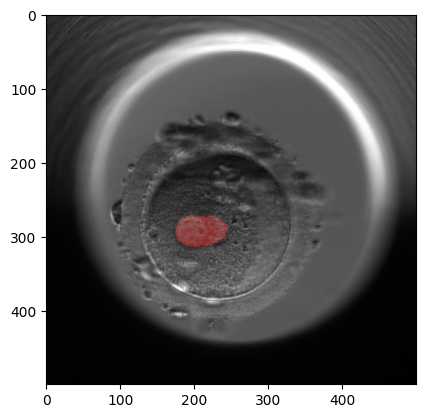

In [219]:
plt.imshow(painted_images[92].transpose(1, 2, 0))

In [115]:
x_axis = np.arange(0, 200) * 10

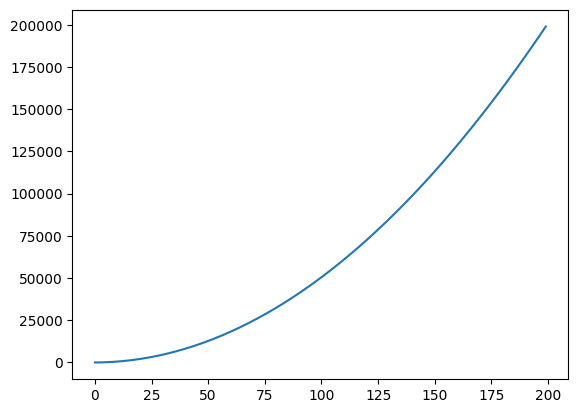

In [117]:
plt.plot(np.cumsum(x_axis))

In [142]:
np.argmax(all_masks.sum(axis=(1, 2)))

np.int64(86)

In [153]:
area = all_masks.sum(axis=(1, 2))

In [173]:
def find_signal(arr: np.ndarray[bool]):
    # Find the largest continuous block of ones
    max_len = 0
    max_start = 0
    curr_len = 0
    curr_start = 0
    for i in range(len(arr)):
        if arr[i] == 1:
            if curr_len == 0:
                curr_start = i
            curr_len += 1
        else:
            if curr_len > max_len:
                max_len = curr_len
                max_start = curr_start
            curr_len = 0
    # Check at the end in case the longest sequence is at the end
    if curr_len > max_len:
        max_len = curr_len
        max_start = curr_start
    return max_start, max_len

In [175]:
max_start, max_len = find_signal(area > 10)

In [177]:
area[:max_start] = 0

area[max_start + max_len:] = 0

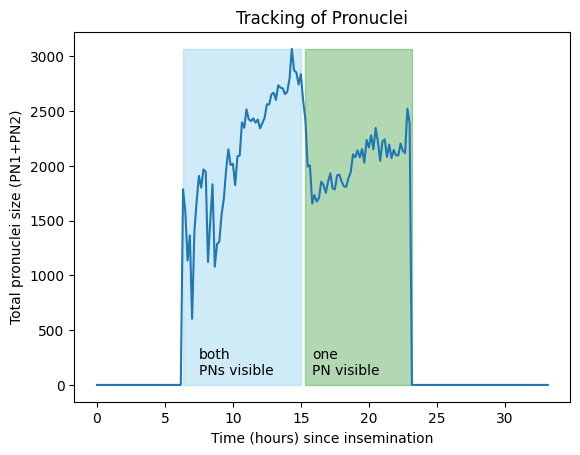

In [228]:
plt.plot([i * 10 / 60 for i in range(200)], area)
plt.xlabel('Time (hours) since insemination')
plt.ylabel('Total pronuclei size (PN1+PN2)')
plt.title('Tracking of Pronuclei')

plt.fill_between([max_start * 10 / 60, 90 * 10 / 60],
                 [area.max(), area.max()],
                 color='skyblue',
                 alpha=0.4)

plt.fill_between([92 * 10 / 60, max_start * 10 / 60 + max_len * 10 / 60],
                 [area.max(), area.max()],
                 color='green',
                 alpha=0.3)
plt.text(45 * 10 / 60, 90, 'both\nPNs visible')

plt.text(95 * 10 / 60, 90, 'one\nPN visible')
plt.savefig("pronuclei_tracking.png", dpi=300, bbox_inches='tight')


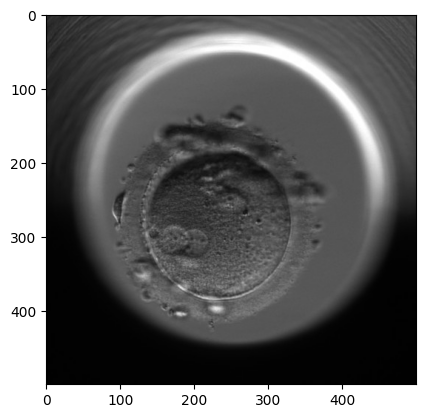

In [57]:
plt.imshow(rgb_img.transpose(1, 2, 0))

In [26]:
mask_arr.sum()

np.uint64(6)

In [5]:
import scipy
from skimage.measure import label, regionprops
from torchvision.transforms.functional import rotate


def mask_orientation_centroid(image: np.ndarray[int]):
    label_img = label(image)
    regions = regionprops(label_img)
    for props in regions:
        y0, x0 = props.centroid
        orientation = props.orientation
        return props.centroid, orientation, props.axis_major_length, props.axis_minor_length


def rotate_image(image_arr: PIL.Image, angle: float | None = None):
    _, orientation, _, _ = mask_orientation_centroid((np.array(image_arr)))

    if angle:
        return rotate(image_arr, angle)
    rotation_angle = -np.rad2deg(orientation) + 90

    return np.array(rotate(image_arr, rotation_angle)), rotation_angle


def find_signal(arr: np.ndarray[bool]):
    # Find the largest continuous block of ones
    max_len = 0
    max_start = 0
    curr_len = 0
    curr_start = 0
    for i in range(len(arr)):
        if arr[i] == 1:
            if curr_len == 0:
                curr_start = i
            curr_len += 1
        else:
            if curr_len > max_len:
                max_len = curr_len
                max_start = curr_start
            curr_len = 0
    # Check at the end in case the longest sequence is at the end
    if curr_len > max_len:
        max_len = curr_len
        max_start = curr_start
    return max_start, max_len

NameError: name 'PIL' is not defined

In [ ]:
image_data = Path(
    '/Users/tsakalis/ntua/cellforge/data/segmentation_data/pronuclei')

In [ ]:
whole_img = PIL.Image.open(
    '/Users/tsakalis/ntua/cellforge/data/segmentation_data/pronuclei/images_pn/348.jpg'
)

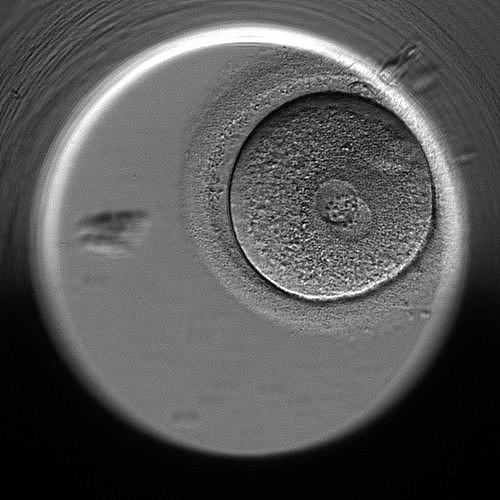

In [577]:
whole_img

In [599]:
import PIL
for img_pth in (image_data / 'masks_pn').glob('*'):
    img = PIL.Image.open(img_pth)

    rotated_image, rotation_angle = rotate_image(img)
    centroid, _, major_axis_length, minor_axis_length = mask_orientation_centroid(
        np.array(rotated_image) > 100)

    y0, x0 = centroid

    rotated_image_orig = rotate_image(
        Image.fromarray((np.array(whole_img) * np.array(img))), rotation_angle)
    # img.show()

    rotated_image_whole = rotate_image(whole_img, rotation_angle)
    # img.show()
    break

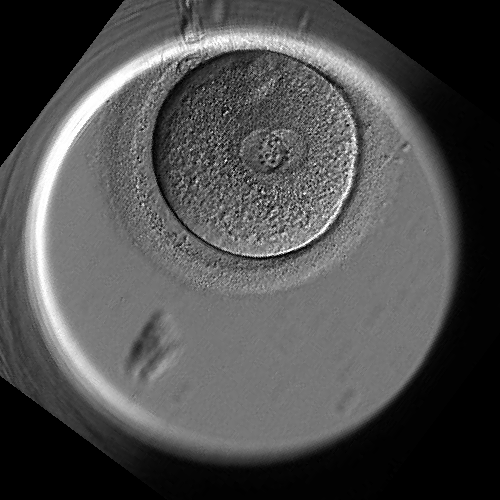

In [600]:
rotated_image_whole

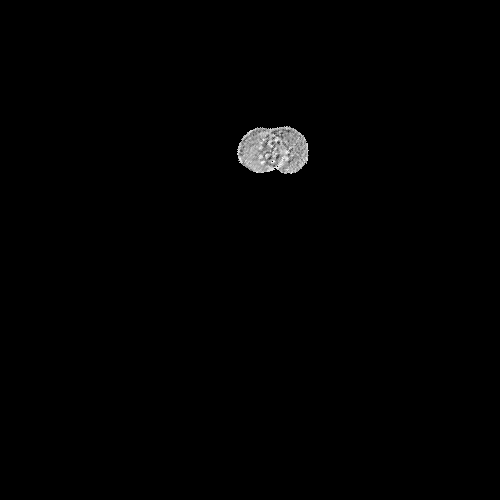

In [579]:
rotated_image_orig

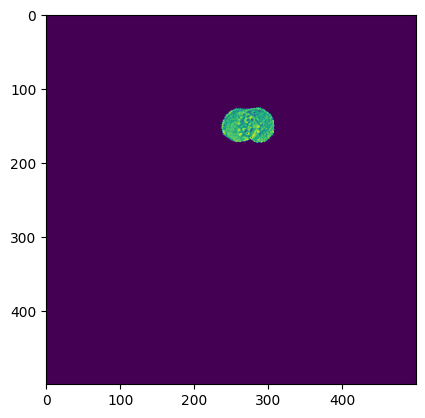

In [580]:
plt.imshow(rotated_image_orig)

In [581]:
rotate_image

<function __main__.rotate_image(image_arr: <module 'PIL.Image' from '/Users/tsakalis/Library/Caches/pypoetry/virtualenvs/cellforge-Tgd_YqAD-py3.11/lib/python3.11/site-packages/PIL/Image.py'>, angle: float | None = None)>

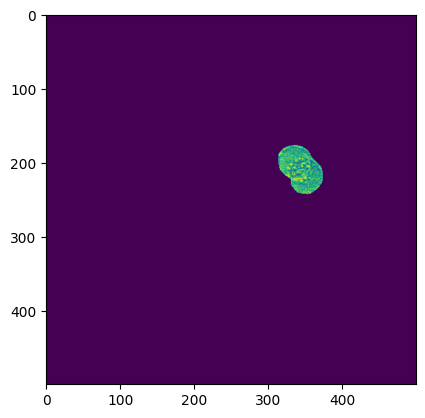

In [582]:
plt.imshow((np.array(whole_img) * np.array(img)))

In [567]:
mask_orientation_centroid(np.array(rotated_image) > 1)


((np.float64(149.82480173035327), np.float64(273.1016582552271)),
 1.5703029589693691,
 74.1719767935052,
 48.25495374418691)

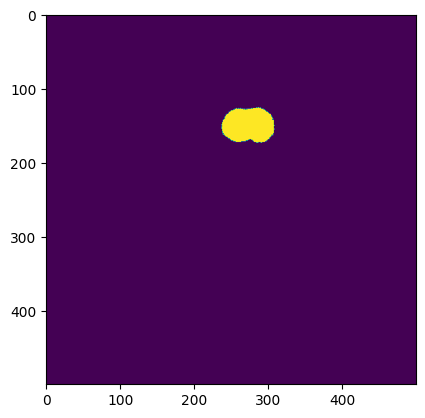

In [592]:
plt.imshow(rotated_image > 100)

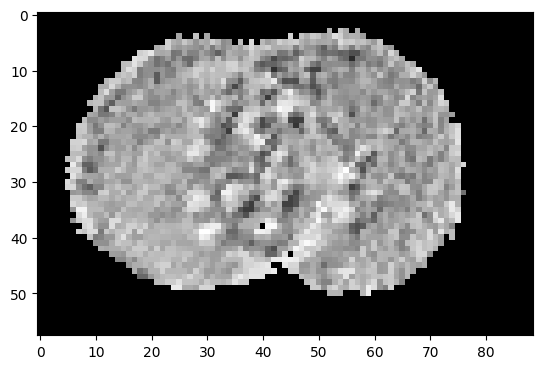

In [570]:
a1 = int(x0 - major_axis_length * 0.55)
b1 = int(x0 + major_axis_length * 0.65)

a2 = int(y0 - minor_axis_length * 0.55)
b2 = int(y0 + minor_axis_length * 0.65)
import cv2

from PIL import Image

width, height = np.array(rotated_image)[a2:b2, a1:b1].shape

isolated_pn = np.array(rotated_image_orig)[a2:b2, a1:b1]

upscaled_img = cv2.resize(rotated_image[a2:b2, a1:b1],
                          None,
                          fx=15,
                          fy=15,
                          interpolation=cv2.INTER_CUBIC)

im = Image.fromarray(upscaled_img).resize((width, height),
                                          resample=Image.LANCZOS)

smoothed_img = cv2.GaussianBlur(np.array(rotated_image[a2:b2, a1:b1]), (9, 9),
                                0)

plt.imshow(isolated_pn, cmap='gray')
plt.show()

# plt.imshow(rotated_image[a2:b2, a1:b1] > 10, cmap='gray')
# plt.show()

In [571]:
isolated_pn

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

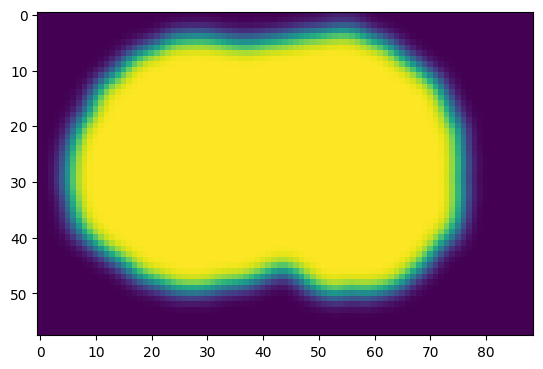

In [572]:
plt.imshow(smoothed_img)

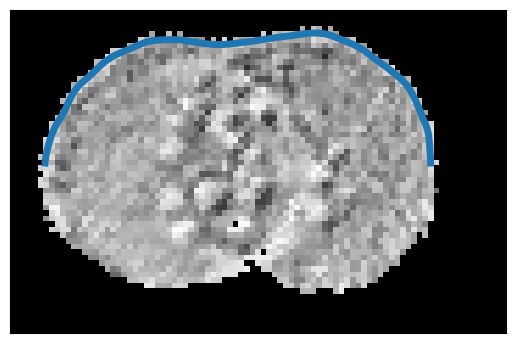

In [671]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import measure

# Construct some test data
x, y = np.ogrid[-np.pi:np.pi:100j, -np.pi:np.pi:100j]
r = np.sin(np.exp(np.sin(x)**3 + np.cos(y)**2))

# Find contours at a constant value of 0.8
contours = measure.find_contours(smoothed_img, 170)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(isolated_pn, cmap=plt.cm.gray)

for contour in contours:
    half_contour = contour[contour[:, 0] < contour[:, 0].mean()]
    ax.plot(half_contour[:, 1], half_contour[:, 0], linewidth=5)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [672]:
import numpy as np
from scipy.signal import argrelextrema

x = np.random.random(12)

# for local maxima
argrelextrema(x, np.greater)

# for local minima
argrelextrema(x, np.less)

(array([ 6,  8, 10]),)

In [673]:
import numpy as np
from scipy import signal

xs = np.arange(0, np.pi, 0.05)
data = half_contour[:, 0]
peakind = signal.find_peaks_cwt(data, np.arange(1, 25))

peakind[1]


np.int64(56)

In [674]:
orientation

NameError: name 'orientation' is not defined

In [675]:
import numpy as np
import matplotlib.pyplot as plt


def fit_ellipse(x, y):
    A = np.stack([x**2, x * y, y**2, x, y]).T
    b = np.ones_like(x)

    return np.linalg.lstsq(A, b)[0].squeeze()


Fitted circle: center=(50.939, -27.991), radius=24.401
Fitted circle: center=(29.903, -28.683), radius=23.827


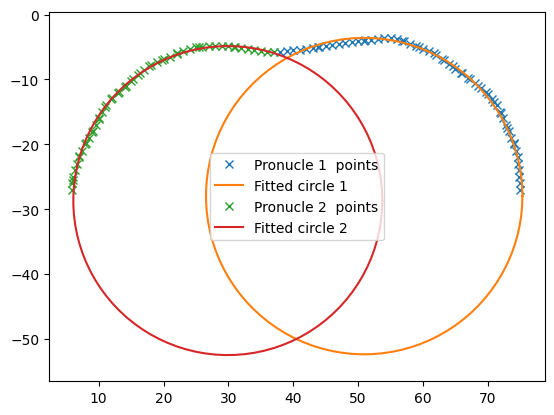

In [676]:
import numpy as np
import matplotlib.pyplot as plt


def fit_circle(x, y):
    """
    Fit a circle to the given x, y points using least squares.
    Returns the circle parameters: x0, y0 (center), and r (radius).
    """
    A = np.c_[2 * x, 2 * y, np.ones_like(x)]
    b = x**2 + y**2
    c = np.linalg.lstsq(A, b, rcond=None)[0]
    x0, y0 = c[0], c[1]
    r = np.sqrt(c[2] + x0**2 + y0**2)
    return x0, y0, r


def get_circle_pts(x0, y0, r, npts=100, tmin=0, tmax=2 * np.pi):
    """
    Return npts points on the circle defined by (x0, y0, r).
    """
    t = np.linspace(tmin, tmax, npts)
    x = x0 + r * np.cos(t)
    y = y0 + r * np.sin(t)
    return x, y


if __name__ == '__main__':
    # Example noisy circle
    np.random.seed(42)

    theta = np.linspace(0, 2 * np.pi, 100)
    x = half_contour[peakind[1]:, 1]
    y = -half_contour[peakind[1]:, 0]

    x0, y0, r = fit_circle(x, y)
    print(f"Fitted circle: center=({x0:.3f}, {y0:.3f}), radius={r:.3f}")

    xf, yf = get_circle_pts(x0, y0, r)

    plt.plot(x, y, 'x', label='Pronucle 1  points')
    plt.plot(xf, yf, '-', label='Fitted circle 1')
    plt.axis('equal')

    x = half_contour[:peakind[1], 1]
    y = -half_contour[:peakind[1], 0]

    x0, y0, r = fit_circle(x, y)
    print(f"Fitted circle: center=({x0:.3f}, {y0:.3f}), radius={r:.3f}")

    xf, yf = get_circle_pts(x0, y0, r)

    plt.plot(x, y, 'x', label='Pronucle 2  points')
    plt.plot(xf, yf, '-', label='Fitted circle 2')
    plt.axis('equal')
    plt.legend()
    plt.show()


In [677]:
np.array(rotated_image_whole).shape

(500, 500)

Fitted circle 1: center=(50.939, -27.991), radius=24.401
Fitted circle 2: center=(29.903, -28.683), radius=23.827


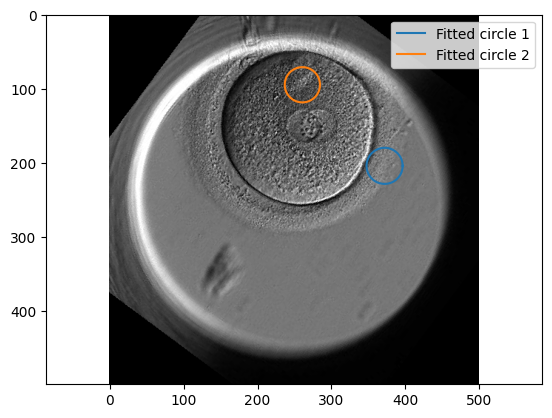

In [678]:
import numpy as np
import matplotlib.pyplot as plt

X0, Y0 = centroid


def fit_circle(x, y):
    A = np.c_[2 * x, 2 * y, np.ones_like(x)]
    b = x**2 + y**2
    c = np.linalg.lstsq(A, b, rcond=None)[0]
    x0, y0 = c[0], c[1]
    r = np.sqrt(c[2] + x0**2 + y0**2)
    return x0, y0, r


def get_circle_pts(x0, y0, r, npts=100, tmin=0, tmax=2 * np.pi):
    t = np.linspace(tmin, tmax, npts)
    x = x0 + r * np.cos(t)
    y = y0 + r * np.sin(t)
    return x, y


if __name__ == '__main__':
    # assume you already have isolated_pn, half_contour, and peakind defined
    fig, ax = plt.subplots()
    ax.imshow(rotated_image_whole, cmap='gray')  # show the image

    # First PN
    x = half_contour[peakind[1]:, 1]
    y = -half_contour[peakind[1]:, 0]
    x0, y0, r = fit_circle(x, y)
    print(f"Fitted circle 1: center=({x0:.3f}, {y0:.3f}), radius={r:.3f}")
    xf, yf = get_circle_pts(b1 + abs(x0), a1 + y0, r)
    # ax.plot(x, y, 'x', label='Pronucle 1 points')
    ax.plot(xf, yf, '-', label='Fitted circle 1')

    # Second PN
    x = half_contour[:peakind[1], 1]
    y = -half_contour[:peakind[1], 0]
    x0, y0, r = fit_circle(x, y)
    print(f"Fitted circle 2: center=({x0:.3f}, {y0:.3f}), radius={r:.3f}")
    xf, yf = get_circle_pts(a1 + abs(y0), y0 + a2, r)
    # ax.plot(x, y, 'x', label='Pronucle 2 points')
    ax.plot(xf, yf, '-', label='Fitted circle 2')

    ax.axis('equal')
    ax.legend()
    plt.show()


Fitted circle 1: center=(50.939, -27.991), radius=24.401
Fitted circle 2: center=(29.903, -28.683), radius=23.827


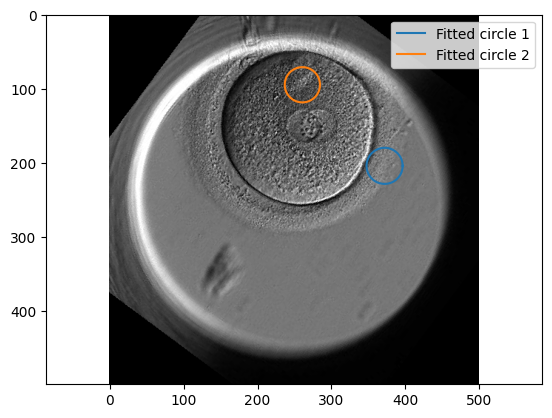

In [679]:
import numpy as np
import matplotlib.pyplot as plt

X0, Y0 = centroid


def fit_circle(x, y):
    A = np.c_[2 * x, 2 * y, np.ones_like(x)]
    b = x**2 + y**2
    c = np.linalg.lstsq(A, b, rcond=None)[0]
    x0, y0 = c[0], c[1]
    r = np.sqrt(c[2] + x0**2 + y0**2)
    return x0, y0, r


def get_circle_pts(x0, y0, r, npts=100, tmin=0, tmax=2 * np.pi):
    t = np.linspace(tmin, tmax, npts)
    x = x0 + r * np.cos(t)
    y = y0 + r * np.sin(t)
    return x, y


if __name__ == '__main__':
    # assume you already have isolated_pn, half_contour, and peakind defined
    fig, ax = plt.subplots()
    ax.imshow(rotated_image_whole, cmap='gray')  # show the image

    # First PN
    x = half_contour[peakind[1]:, 1]
    y = -half_contour[peakind[1]:, 0]
    x0, y0, r = fit_circle(x, y)
    print(f"Fitted circle 1: center=({x0:.3f}, {y0:.3f}), radius={r:.3f}")
    xf, yf = get_circle_pts(b1 + abs(x0), a1 + y0, r)
    # ax.plot(x, y, 'x', label='Pronucle 1 points')
    ax.plot(xf, yf, '-', label='Fitted circle 1')

    # Second PN
    x = half_contour[:peakind[1], 1]
    y = -half_contour[:peakind[1], 0]
    x0, y0, r = fit_circle(x, y)
    print(f"Fitted circle 2: center=({x0:.3f}, {y0:.3f}), radius={r:.3f}")
    xf, yf = get_circle_pts(a1 + abs(y0), y0 + a2, r)
    # ax.plot(x, y, 'x', label='Pronucle 2 points')
    ax.plot(xf, yf, '-', label='Fitted circle 2')

    ax.axis('equal')
    ax.legend()
    plt.show()


Fitted circle 1: center=(50.939, -27.991), radius=24.401
Fitted circle 2: center=(29.903, -28.683), radius=23.827


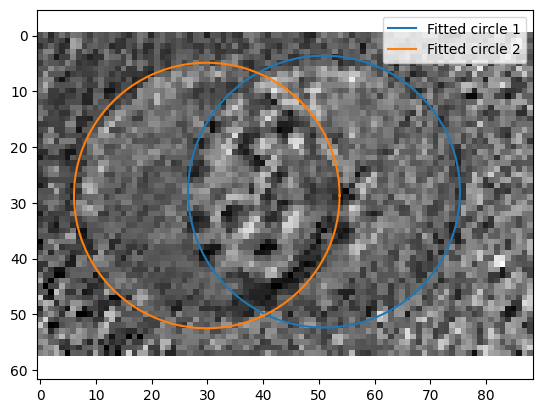

In [680]:
import numpy as np
import matplotlib.pyplot as plt

X0, Y0 = centroid


def fit_circle(x, y):
    A = np.c_[2 * x, 2 * y, np.ones_like(x)]
    b = x**2 + y**2
    c = np.linalg.lstsq(A, b, rcond=None)[0]
    x0, y0 = c[0], c[1]
    r = np.sqrt(c[2] + x0**2 + y0**2)
    return x0, y0, r


def get_circle_pts(x0, y0, r, npts=100, tmin=0, tmax=2 * np.pi):
    t = np.linspace(tmin, tmax, npts)
    x = x0 + r * np.cos(t)
    y = y0 + r * np.sin(t)
    return x, y


if __name__ == '__main__':
    # assume you already have isolated_pn, half_contour, and peakind defined
    fig, ax = plt.subplots()
    ax.imshow(np.array(rotated_image_whole)[a2:b2, a1:b1],
              cmap='gray')  # show the image

    # First PN
    x = half_contour[peakind[1]:, 1]
    y = -half_contour[peakind[1]:, 0]
    x0, y0, r = fit_circle(x, y)
    print(f"Fitted circle 1: center=({x0:.3f}, {y0:.3f}), radius={r:.3f}")
    xf, yf = get_circle_pts(x0, -y0, r)
    # ax.plot(x, y, 'x', label='Pronucle 1 points')
    ax.plot(xf, yf, '-', label='Fitted circle 1')

    # Second PN
    x = half_contour[:peakind[1], 1]
    y = -half_contour[:peakind[1], 0]
    x0, y0, r = fit_circle(x, y)
    print(f"Fitted circle 2: center=({x0:.3f}, {y0:.3f}), radius={r:.3f}")
    xf, yf = get_circle_pts(x0, -y0, r)
    # ax.plot(x, y, 'x', label='Pronucle 2 points')
    ax.plot(xf, yf, '-', label='Fitted circle 2')

    ax.axis('equal')
    ax.legend()
    plt.show()


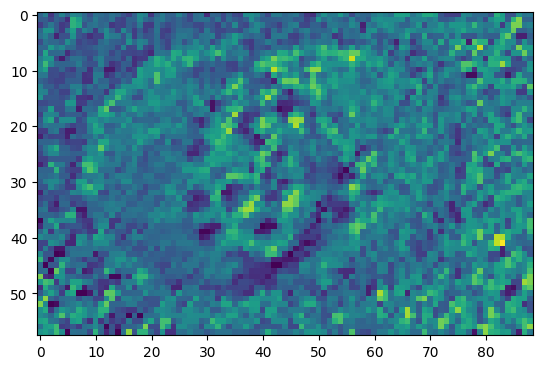

In [664]:
plt.imshow(np.array(rotated_image_whole)[a2:b2, a1:b1])

In [ ]:
rotated_image_whole[]

In [682]:
metadata_pth = Path('/Users/tsakalis/Downloads/metadata')

/Users/tsakalis/Downloads/metadata/accumulated_pn_area_D2016.01.11_S1183_I149_1.npy


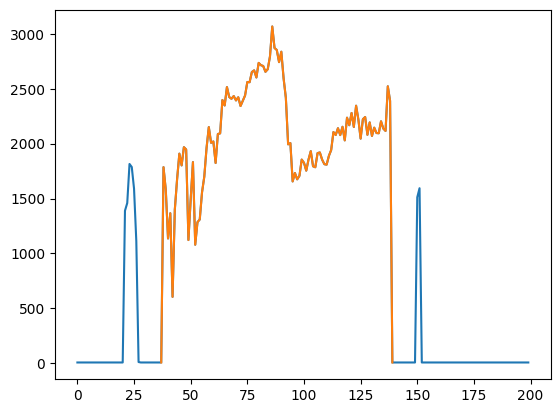

In [685]:
for path in list(metadata_pth.glob('*'))[1:40]:
    if str(
            path
    ) != '/Users/tsakalis/Downloads/metadata/accumulated_pn_area_D2016.01.11_S1183_I149_1.npy':
        continue

    area = np.load(path)

    max_start, max_len = find_signal(area > 10)

    signal_frames = np.arange(max_start - 1, max_start + 1 + max_len)
    plt.plot(area)

    plt.plot(signal_frames, area[max_start - 1:max_start + max_len + 1])
    print(path)
    plt.show()


In [687]:
max_start

38

In [ ]:
timestemps = pd.read_csv('')

In [686]:
max_start

38